## Using SAS DLPy to Create a Deep Neural 1D Convolution Model For Time Series Data 

This example uses SAS DLPy to create and train a deep neural network that uses 1-D convolutions with time series data. The analytic task is to use x-, y-, and z-axis accelerometer data to classify a subject's activity from a set of six activity classes. 

This notebook example uses the Wireless Sensor Data Mining (WISDM) Lab data. The WISDM lab data from Fordham University is public and can be downloaded from [WISDM Labs](http://www.cis.fordham.edu/wisdm/dataset.php). The data was collected in controlled laboratory conditions using accelerometer sensors to identify 6 activities in a subject. The 6 activities are as follows:

* Walking
* Jogging
* Ascending stairs (Upstairs)
* Descending stairs (Downstairs)
* Sitting
* Standing.

This example follows a Keras model that was created for analytic sequences and is shown in [Nils Ackerman's blog](https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf). The model uses the codes from the [Human Activity Recognition (HAR) CNN Network](https://github.com/ni79ls/har-keras-cnn).

This neural network 1-D convolution example for time series data takes the following steps:

* Import Python utility modules
* Download the Example Data
* Prepare and Transform Data
* Launch SAS CAS
* Load and Explore the Data
* Split the Training Data
* Create the Model with 1-D Convolutions
* Train the Model with 1-D Convolutions
* Assess the Trained Model Performance. 

### Table of Contents

- [Prepare Resources and Configure Environment for Modeling](#getReady)
    - [Important Note: Client-Side Definitions](#clientSide)
    - [Import Required Python and SAS DLPy Utilities](#importPythonDLPy)
    - [Download the WISDM Example Data](#downloadWISDM)
- [Prepare and Transform the WISDM Data](#prepareTransform)
    - [Explore the Transformed Model Data](#exploreTransformed)
    - [Extract Features and Partition the WISDM Data](#extractPartition)
    - [Convert Train and Test Arrays to Dataframes](#convertDataframe)
- [Configure SAS SWAT and Launch SAS CAS](#launchCAS)
- [Load the Train and Test Data into SAS CAS](#loadData)
    - [Split the Training Data into Train and Validation Partitions](#splitData)    
- [Create a Deep Neural Network with 1D Convolutions](#createNetwork)
- [Train the Deep Neural 1D Convolution Model](#trainModel)
- [Examine Neural Network Classification Model Performance Metrics](#Plots)
    - [Evaluate the Confusion Matrix](#confusionMatrix)
    - [Calculate the Model's Predictive Accuracy](#predAccuracy)
    - [Assess ROC Curve and Calculate AUC](#rocAUC)
    - [Evaluate Precision-Recall Curve](#precisionRecall)
    - [Evaluate Average Precision and F1 Scores](#f1Average)
- [Summary](#summary)    


<a id = "getReady"></a>

### Prepare Resources and Configure Computing Environment for Modeling

Use this section to organize all of the resources you need and configure your local computing environment in advance, so you can follow along with the example notebook modeling operations without interruption. 

<a id="clientSide"></a>

#### Important Note: Client-Side Definitions

SAS Viya literature and technical documentation often refers to client and server entities. In this scenario, the client is the computer that runs the Jupyter notebook with the example code. The server is the computer that is running the Viya server. These two computers might (or might not) use the same operating system, and might (or might not) have access to a common file system. The code below uses the `client_project_root` variable to specify a client-side path to the root folder that contains the example files in your computing environment. 

In [1]:
# This code defines a client-side path variable used in 
# the code to specify the location for input data files,
# model files, and analytic data tables in the example.

# Client project root location (your path will be different)
client_project_root = r'\\your-client-side\path-to\example-files

<a id="importPythonDLPy"></a>

#### Import Required Python and SAS DLPy Utilities

Use this section to import the Python utility libraries and SAS DLPy libraries that will be used for the fully-connected feedforward neural network classification model. 

Import the Python and SAS DLPy utilities required for the model task. They include the scikit-Learn utility, the Pandas data analysis library, the numPy scientific computing library, and the matplotlib plotting utility.

In [2]:
# Import various Python scientific computing 
# data manipulation, and plotting modules 
import pandas as pd
import numpy as np
from scipy import stats
from sklearn import preprocessing
import matplotlib.pylab as plt

# Import SAS Scripted Wrapper for Analytics Transfer (SWAT) modules.
from swat.cas import datamsghandlers
from swat import CAS, CASTable

# Specify and load selected DLPy modules.
from dlpy import Model, Sequential
from dlpy.model import Optimizer, MomentumSolver, AdamSolver, Gpu
from dlpy.layers import * 
from dlpy.splitting import two_way_split
from dlpy.metrics import *

<a id="downloadWISDM"></a>

#### Download the WISDM Example Data

Now download the WISDM accelerator data from the [Wireless Sensor Data Mining page](https://www.cis.fordham.edu/wisdm/dataset.php). Select the [Dowload Latest Version](https://www.cis.fordham.edu/wisdm/includes/datasets/latest/WISDM_ar_latest.tar.gz) button to download to your computing environment the file `WISDM_ar_latest.tar.gz`. Use the file decompression utility of your choice to extract the file `WISDM_ar_v1.1_raw.txt` and save it to the location you specified earlier for `client_project_root`. The downloaded file `WISDM_ar_latest.tar.gz` is in CSV format and is approximately 49MB in size.

<a id="prepareTransform"></a>

### Prepare and Transform the WISDM Example Data

The following block of code defines functions that the notebook example uses to prepare and transform the WISDM data for predictive modeling. Some of the functions used to read and transform the WISDM data in the following code are copied from the [Human Activity Recognition (HAR) with 1D Convolutional Neural Network in Python and Keras](https://github.com/ni79ls/har-keras-cnn).

If you like using open source APIs to process data, this example shows how you can use the SAS DLPy 
 open-source API to integrate SAS Deep Learning with your open-source code. 

In [3]:
# Define the custom functions used in subsequent code.
# Use this code block as-is; no changes are required
# for example notebook use.

# Normalize Data Set Features 
def feature_normalize(dataset):

    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu)/sigma

# Read CSV Data from File
def read_data(file_path):

    """
    This function reads the accelerometer data from a file.

    Args:
        file_path: client-side path specification to the 
        CSV file containing the accelerometer data.

    Returns:
        A Pandas dataframe
    """

    # Create columns in the dataframe
    column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
    
    # Read CSV data into the dataframe
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    
    # Remove the ";" character from the data in 
    # the last column (z-axis) of the raw table.
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    
    # Transform values in z-axis to floating point
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    
    # Remove missing values. This function is 
    # required for the model to train and prevents 
    # loss values from displaying as NAN.
    df.dropna(axis=0, how='any', inplace=True)

    return df


# Convert values to floating point values
def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan


# Generate plot entities
def plot_axis(ax, x, y, title):

    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)


# Time series plot by activity type
def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(15, 10),
         sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'x-axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'y-axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()


# Reshape table using segment-label entities    
def create_segments_and_labels(df, time_steps, step, label_name):

    """
    This function receives a dataframe and returns the reshaped segments
    of x,y,z acceleration as well as the corresponding labels

    Args:
        df: Dataframe in the expected format
        time_steps: Integer value of the length of a segment that is created
        
    Returns:
        reshaped_segments
        labels:
    """

    # x, y, z acceleration as features
    N_FEATURES = 3
    
    # Number of steps to advance in each iteration. To prevent 
    # overlap between segments, it is recommended to set the 
    # number of steps to be equal to the time_steps.
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
    
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels



Define the labels for each activity type, and load the raw data into a Pandas dataframe:

In [4]:
# The WISDM data has six labels that 
# describe the subject activity classes:

LABELS = ["Downstairs",
          "Jogging",
          "Sitting",
          "Standing",
          "Upstairs",
          "Walking"]

# Load data set containing all the data from csv 
# into a dataframe
df = read_data(client_project_root+'\WISDM_ar_v1.1_raw.txt')

Map integer values to activity types so they can be classified numerically.  

In [5]:
# Convert the labels into integer mapping
# Define column name of the label vector
LABEL = "ActivityEncoded"

# Transform the labels from String to 
# Integer via LabelEncoder
le = preprocessing.LabelEncoder()

# Add a new column to the existing dataframe with the encoded values
df[LABEL] = le.fit_transform(df["activity"].values.ravel())

Use the `head()` function to display the first five rows of the input dataframe with the ActivityEncoded column.

In [6]:
df.head(5)

,user-id,activity,timestamp,x-axis,y-axis,z-axis,ActivityEncoded
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,1
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,1
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,1
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,1
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,1


The first five value counts in the table above are time-stamped activity observations encoded by activity type. The rows all show value counts for the _Jogging_ `activity` by `user-id` _33_, but the dataframe contents are much more diverse when explored as a whole. Use the `value_counts()` function to show how the training example counts are distributed across the different activities in the dataframe.  

In [7]:
df["activity"].value_counts()

Walking       424397
Jogging       342176
Upstairs      122869
Downstairs    100427
Sitting        59939
Standing       48395
Name: activity, dtype: int64

The output displays the activity counts in descending order. We can see the most instances occurred for Walking and Jogging, while Sitting and Standing activity counts have the fewest instances.

You can also use the `value_counts()` function to show how the value counts are distributed across the different activities in the dataframe.

In [8]:
df["user-id"].value_counts()

20    56632
19    45383
31    44282
8     41188
29    38245
14    38192
13    37093
34    35947
32    35506
21    35436
3     35161
27    34958
10    34883
18    32811
12    32641
26    32578
36    32261
11    31658
7     30967
1     29978
6     29704
33    29453
5     28509
15    28154
24    25736
23    25673
30    25335
2     23525
35    22394
22    22310
17    22020
28    21358
16    20470
25    13468
9     12923
4     11371
Name: user-id, dtype: int64

The output above gives a a better idea of how the different activites are represented in the data. For all activities, user 20 was the most active with 56,632 training examples, and user 4 was the least active, with 11,371 training examples.

Tabular data is useful, but charts can provide more meaningful insight into the different aspects of the data. For starters, we can explore the data by activity type and user. First, plot the training examples by activity type.

<a id="exploreTransformed"></a>

#### Explore the Transformed Model Data

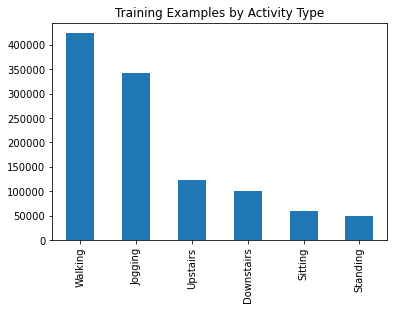

In [9]:
# Explore the data and plot the 
# training examples by activity type.
df['activity'].value_counts().plot(kind='bar',
                                   title='Training Examples by Activity Type')
plt.show()


The data shows an active population; bars for walking and jogging activities represent far more event counts than sitting and standing. 

Next, plot the training examples by user-id. Did all the participants have similar activity levels?

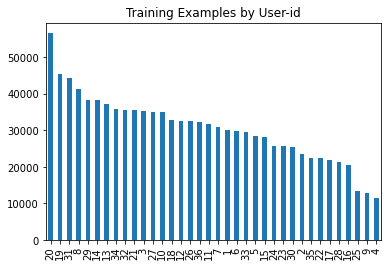

In [10]:
# Plot the training examples by user-id
df['user-id'].value_counts().plot(kind='bar',
                                  title='Training Examples by User-id'
                                  )
plt.show()



The training example plot is accumulated by user-id and sorted in descending order. No, the study subjects did not all share similar activity levels. User 20 had the most counts with 56,632 and user 4 had the fewest with 11,371.

Plotting lets you explore the time-series aspects of the data and the three-dimensional movement captured in the x-, y-, and z- axis accelerometer data. The code below plots accelerometer movements for the time series data for the span between segment 0 and segment 180. The output will be three (x-, y-, and z- axis movement) accelerometer plots for each of the six activity types:

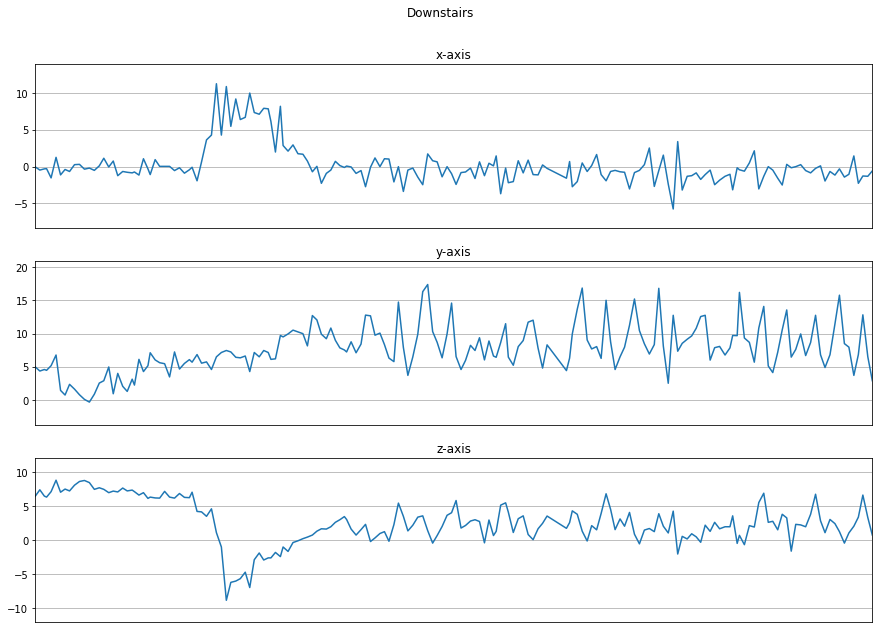

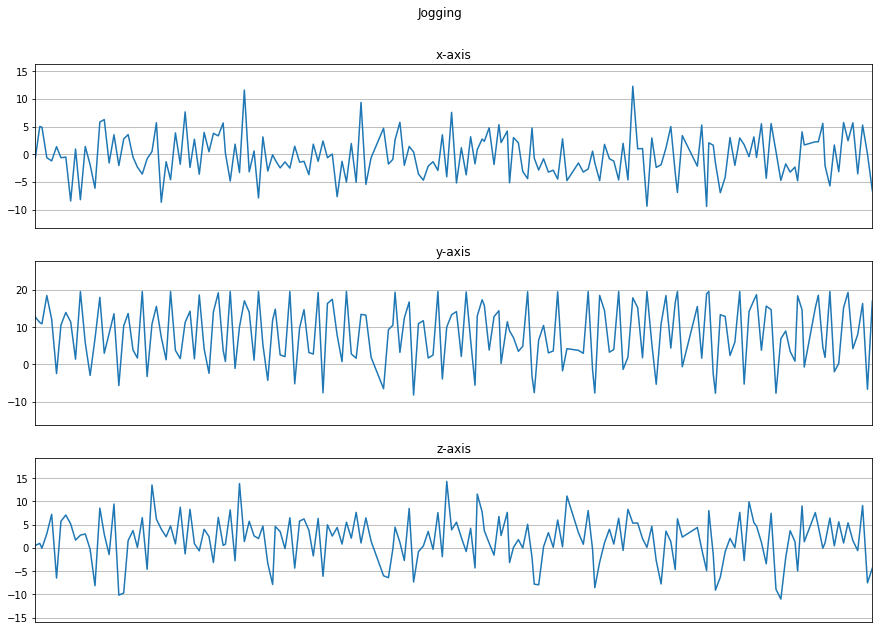

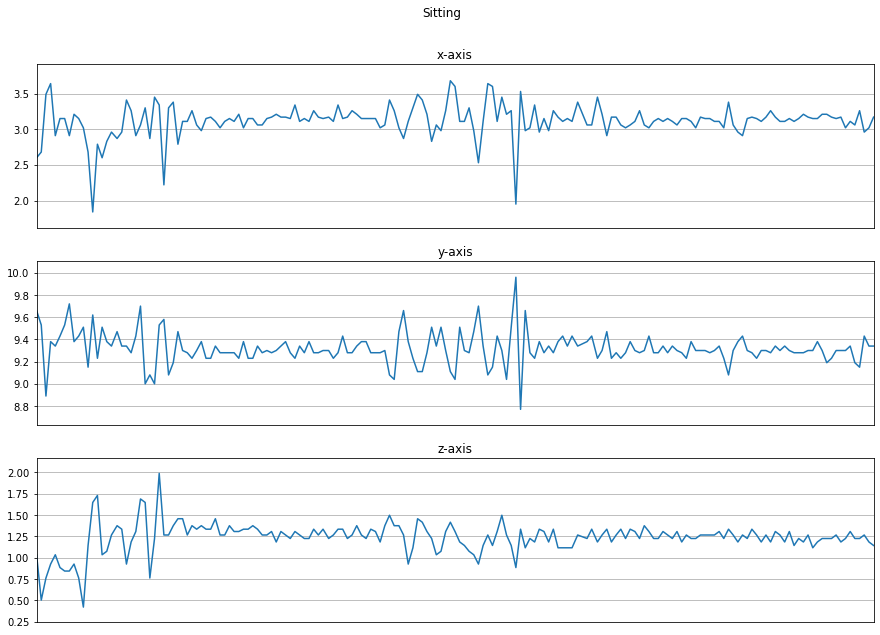

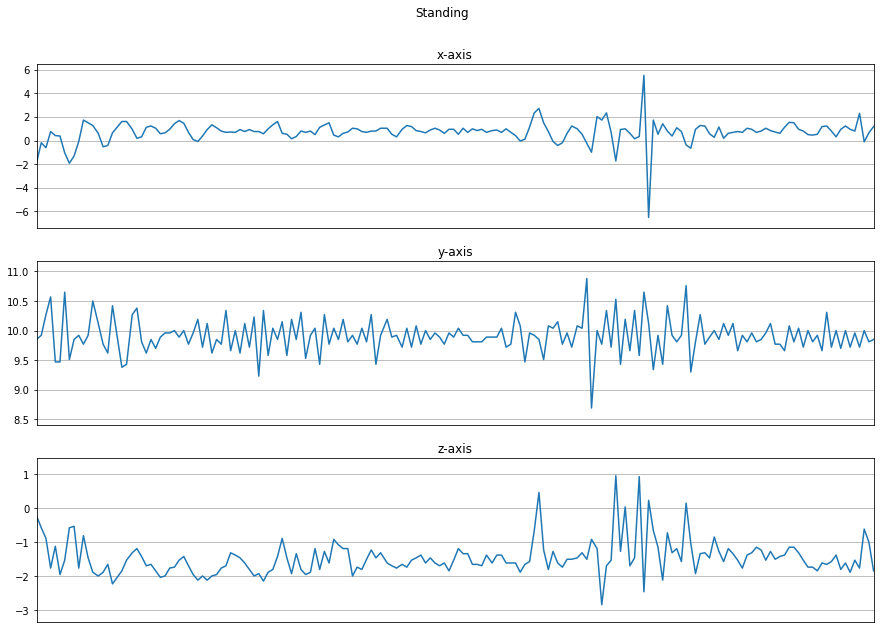

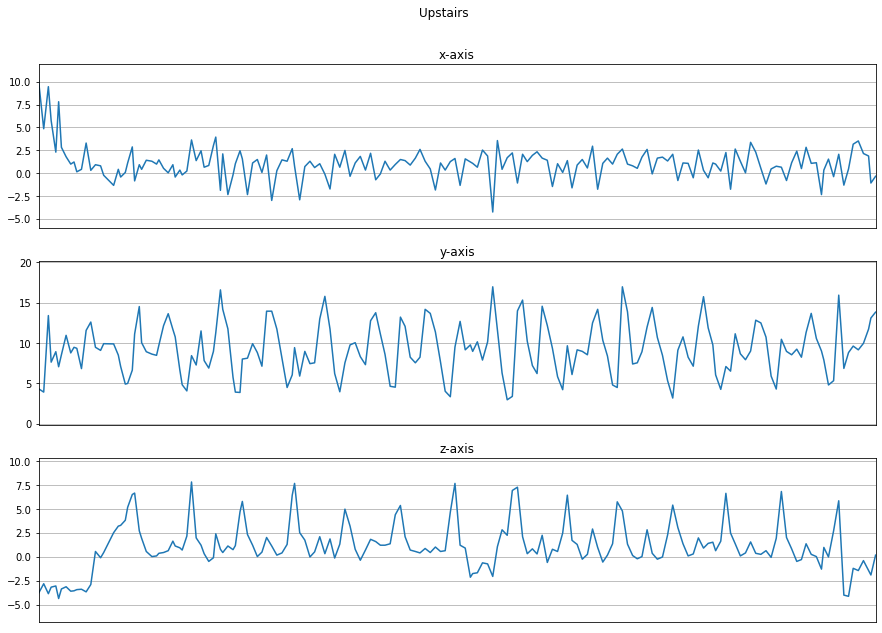

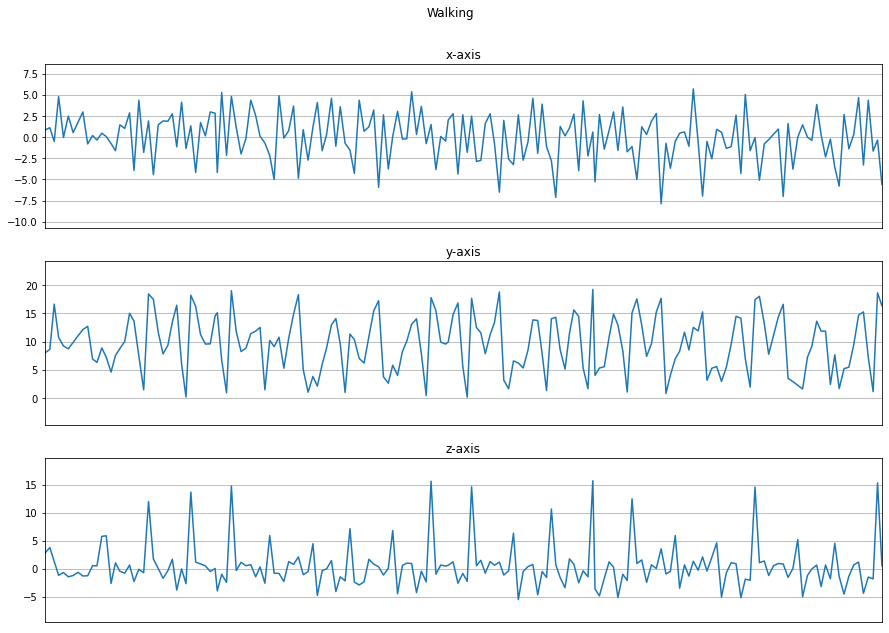

In [11]:
# For each activity type, plot the x-, y-, and z- axis 
# accelerometer movements for the time series data 
# from segment 0 to segment 180.

for activity in np.unique(df["activity"]):
    subset = df[df["activity"] == activity][:180]
    plot_activity(activity, subset)


We have demonstrated that the dataframe contains robust data for three dimensional movements across six activity types for 33 user-ids. Prepare the data for modeling by extracting features from the time series data and then split the data into train and test partitions. 

The data is partitioned into train and test data sets by user-id: the activities of users 1 - 28 comprise the train (85%) data set and users 29-33 comprise the test (15%) data set.

<a id="extractPartition"></a>

#### Extract Features and Partition the WISDM Data

Extract featrues from the downloaded WISDM data and use the `user-id`s to divide the data into train (85%) and test (15%) partitions. 

In [12]:
# Extract the features from time series data
# Split the data into train and test based on user ids

# Define time segment metrics for analysis and labeling
# Define the number of steps in one time segment
TIME_PERIODS = 80

# The steps to take from one segment to the next. If set equal to
# TIME_PERIODS, there is no overlap between the segments
STEP_DISTANCE = 40

# Define dataframes for the test data set and the training data set
df_test = df[df['user-id'] > 28]
df_train = df[df['user-id'] <= 28]

# Reshape the training data into segments
# so that they can be processed by the network
x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)

Now use the `head()` function to show sample rows with column headings from the newly created train and test tables. First, the train table: 

In [13]:
df_train.head()

,user-id,activity,timestamp,x-axis,y-axis,z-axis,ActivityEncoded
8489,17,Walking,57869902574000,0.572055,9.806650,-0.531194,5
8490,17,Walking,57870012316000,-0.000000,10.188020,-0.572055,5
8491,17,Walking,57870122301000,-0.231546,9.847511,-0.694638,5
8492,17,Walking,57870222246000,0.149824,10.079058,-0.503953,5
8493,17,Walking,57870332292000,0.149824,10.147159,-0.612916,5


Next, the test table:

In [14]:
df_test.head()

,user-id,activity,timestamp,x-axis,y-axis,z-axis,ActivityEncoded
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,1
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,1
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,1
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,1
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,1


As expected, `user-id`s in the train table are lower than 28, and `user-id`s in the test table are between 29 and 33. 

We can use the numpy `shape()` function to understand the dimensionality of a numPy array. The `shape()` function returns a tuple, with each index having the number of corresponding elements.

For the x-axis train table:

In [15]:
x_train.shape

(20868, 80, 3)

The dimensionality of the `x_train` table is 20,868 observations, 80 time segments, and 3 labels per segment.

In [16]:
y_train.shape

(20868,)

The dimensionality of the `y_train` table is simply 20,868 observations. There are no time segments or labels.

Now prepare formatted tables for the test data by using the `create_segments_and_labels()`function to create `x_test` and `y_test`.

In [17]:
# Create test data tables x_test and y_test
x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

Use the numpy `shape()` function to examine the dimensionality of the test arrays.

For the x-axis test array:

In [18]:
x_test.shape

(6584, 80, 3)

The dimensionality of the array `x_test` is 6,584 observations, 80 time segments, and 3 labels per segment.

In [19]:
y_test.shape

(6584,)

The dimensionality of the array `y_test` is 6,584 observations. As expected, it has no time segments or labels.

<a id="convertDataframe"></a>

#### Convert Train and Test Arrays to Data Frames

The current tables `x_train`, `y_train`, `x_test`, and `y_test` were created as numPy arrays. This step reshapes the data and converts the numpy arrays to Pandas dataframes. The train data table `x_train` is reshaped and saved as `x_train1`, and the test data table `x_test` is reshaped and saved as `x_test1`.

The original array `x_train` dimensions were 20,868 observations, 80 steps, and 3 labels per step. The `reshape()` function creates a train dataframe that has 20,868 observations and 240 labeled step columns.

In [20]:
x_train1 = x_train.reshape(-1, 240)

The `shape()` function returns a tuple, with each index having the number of corresponding elements. In the results below, we expect to see 20,868 observations and 240 columns.

In [21]:
x_train1.shape

(20868, 240)

The original array `x_test` dimensions were 6,584 observations, 80 steps, and 3 labels per step. The `reshape()` function creates a test dataframe that has 6,584 observations and 240 columns.

In [22]:
x_test1 = x_test.reshape(-1, 240)

As expected, we see in the following results 6,584 observations and 240 labeled step columns.

In [23]:
x_test1.shape

(6584, 240)

Use the  Pandas `DataFrame.from_records()` function to create dataframes for `train_data` and `test_data`. Define the target `y_train` as the encoded activity for each row instance in the `train_data` dataframe. 

In [24]:
train_data = pd.DataFrame.from_records(x_train1)

train_data['Activity'] = y_train

Use the `head()` function to display sample rows from the `train_data` table.

In [25]:
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,231,232,233,234,235,236,237,238,239,Activity
0,0.572055,-0.000000,-0.231546,0.149824,0.149824,0.612916,0.108963,-0.108963,-0.081722,0.313268,...,-3.296124,0.313268,-1.988571,-0.231546,-1.797886,-2.410802,-0.231546,0.994285,4.985047,5
1,1.457377,1.539099,2.410802,3.786457,2.560625,1.539099,1.729784,0.844462,0.081722,2.070293,...,-4.140586,-1.076007,-2.833032,-0.653777,0.531194,-4.018003,-0.612916,-1.144109,5.366417,5
2,2.029432,2.410802,-0.803600,2.410802,5.516241,2.982856,1.035146,1.838747,0.762739,2.792171,...,-4.099725,-0.149824,0.190685,-0.340509,-1.797886,-0.912563,-0.231546,2.533385,7.014479,5
3,-0.108963,-1.307553,2.833032,3.486809,4.331271,5.216593,0.463092,3.827318,0.381370,4.753501,...,0.762739,-2.492524,-0.299648,-0.994285,-3.636633,0.422231,-0.503953,3.486809,5.475380,5
4,1.879608,2.764930,1.757025,4.208687,6.851035,0.503953,1.607201,2.029432,1.607201,1.539099,...,-1.334794,-0.340509,0.108963,-1.729784,0.381370,-0.340509,0.531194,5.325556,-2.369941,5


Use the Pandas `DataFrame.from_records()` function to create dataframes for `test_data`. Define `y_test` as the target for each observation in the `test_data` table. 

In [26]:
test_data = pd.DataFrame.from_records(x_test1)

test_data['Activity'] = y_test

Use the `head()` function to display sample rows from the `test_data` table.

In [27]:
test_data.head()

,0,1,2,3,4,5,6,7,8,9,...,231,232,233,234,235,236,237,238,239,Activity
0,-0.694638,5.012288,4.903325,-0.612916,-1.184970,1.375655,-0.612916,-0.503953,-8.430995,0.953424,...,6.442424,1.416516,-6.020194,-6.428804,-0.272407,4.440233,1.144109,-2.724070,8.471856,1
1,5.666065,0.231546,-4.821603,1.838747,-3.296124,11.604536,-3.173541,0.612916,-7.886181,3.146300,...,3.255263,0.108963,5.979332,0.190685,11.141444,3.255263,0.762739,8.008764,-0.381370,1
2,0.422231,-3.568531,-4.671779,-2.138395,-1.334794,-2.914754,3.527670,-4.058864,7.586534,-5.175732,...,-2.751310,9.888372,5.407278,4.671779,1.184970,-3.445948,7.436710,-8.921328,-11.032481,1
3,-1.525479,-4.753501,1.797886,-0.803600,-1.225831,-4.630918,1.988571,-4.630918,12.299174,0.994285,...,7.627395,-8.349273,9.575105,2.220117,4.481094,0.081722,-5.856750,7.123442,-9.112013,1
4,-1.729784,-3.214402,-2.301839,-4.794363,4.058864,1.688923,2.260978,2.260978,5.597963,-2.070293,...,-11.536434,-8.812365,4.290410,2.220117,8.349273,5.788648,-9.888372,1.797886,-1.334794,1


<a id="launchCAS"></a>

### Configure SAS SWAT and Launch SAS CAS

The following code configures SAS SWAT and launches SAS CAS. SWAT is a Python interface to SAS CAS that enables you to load data into memory and apply CAS actions to the data. SAS examples use a default ID of 5570 to specify the port assignment for the CAS connection. You can use a unique number of your own choosing when you assign your port ID. 

<b>Note:</b> For more information about starting a CAS session with the SWAT package, see https://sassoftware.github.io/python-swat/getting-started.html.

In [28]:
# Configure SWAT and launch CAS

# Import SAS SWAT
import swat
from swat import *

# SWAT data message handler
import swat.cas.datamsghandlers as dmh

# Connect to the SAS CAS Server
s = CAS('your-host-name.unx.company-name.com', 5570)

<a id="loadData"></a>

### Load the Train and Test Data into SAS CAS

Use the code block below to upload the train and test dataframes into SAS CAS and save them as CAS tables `train_tbl` and `test_tbl`. First, use the `upload_frame()` function to create a CAS table `train` that is saved to Python as `train_tbl` from the Pandas dataframe `train_data`:

In [29]:
train_tbl = s.upload_frame(train_data, 
                           casout=dict(name='train', 
                                       replace=True
                                       )
                           )

NOTE: Cloud Analytic Services made the uploaded file available as table TRAIN in caslib CASUSER(UserID).
NOTE: The table TRAIN has been created in caslib CASUSER(UserID) from binary data uploaded to Cloud Analytic Services.


Now, use the `upload_frame()` function to create a CAS table `test` that is saved to Python as `test_tbl` from the Pandas dataframe `test_data`:

In [30]:
test_tbl = s.upload_frame(test_data, 
                          casout=dict(name='test', 
                                      replace=True
                                      )
                          )

NOTE: Cloud Analytic Services made the uploaded file available as table TEST in caslib CASUSER(UserID).
NOTE: The table TEST has been created in caslib CASUSER(UserID) from binary data uploaded to Cloud Analytic Services.


What does the data in the new train table look like? How are the activity labels distributed throughout the data? Use the `freq()` function to examine the frequency distribution: 

In [31]:
# Display a frequency table of encoded 
# activity labels in the train data
train_tbl.freq(inputs='activity')

,Column,NumVar,FmtVar,Level,Frequency
0,Activity,0.0,0,1,1864.0
1,Activity,1.0,1,2,6567.0
2,Activity,2.0,2,3,1050.0
3,Activity,3.0,3,4,833.0
4,Activity,4.0,4,5,2342.0
5,Activity,5.0,5,6,8212.0


The results table for the train data above displays 6 numeric encoded activity levels. Each encoded level represents a different activity. For example, level 1 represents the activity `downstairs`, level 2 represents the activity `walking`, level 3 represents the activity `sitting`, level 4 represents the activity `standing`, level 5 represents the activity `upstairs`,  and level 6 represents the activity `jogging`.    

Let's look at the same frequency table again, this time using the test data `test_tbl`:

In [32]:
test_tbl.freq(inputs='activity')

,Column,NumVar,FmtVar,Level,Frequency
0,Activity,0.0,0,1,650.0
1,Activity,1.0,1,2,1990.0
2,Activity,2.0,2,3,452.0
3,Activity,3.0,3,4,370.0
4,Activity,4.0,4,5,725.0
5,Activity,5.0,5,6,2397.0


The results table for the test data above displays the 6 numeric encoded activity levels. As with table 1, each encoded level represents a different activity. For example, level 1 represents the activity `downstairs`, level 2 represents the activity `walking`, level 3 represents the activity `sitting`, level 4 represents the activity `standing`, level 5 represents the activity `upstairs`,  and level 6 represents the activity `jogging`.  The frequency tables for both the train and test data show the same order of activities when ranked by frequency of occurence.

The table `train_tbl` is very wide, with 240 columns. You can use the `summary()` function with the `inputs=` specification to generate a table of standard statistical values for two columns in the train table. The code below displays summary statistics for columns `100` and `210`: 

In [33]:
# check some feature summaries
train_tbl.summary(inputs=['100', '210'])

,Column,Min,Max,N,NMiss,Mean,Sum,Std,StdErr,Var,USS,CSS,CV,TValue,ProbT,Skewness,Kurtosis
0,100,-19.610001,20.040001,20868.0,0.0,7.138939,148975.371962,6.747646,0.046710,45.530726,2.013616e+06,950089.661291,94.518895,152.834632,0.000000e+00,-0.578678,0.877895
1,210,-19.799999,19.610001,20868.0,0.0,0.482629,10071.497045,4.831241,0.033444,23.340886,4.919151e+05,487054.270507,1001.026255,14.430951,5.565173e-47,0.286330,1.231190


The table test_tbl is also 240 columns wide. Use the `summary()` function again with the inputs= specification to generate a table of standard statistical values for two selected columns in the test table. The code below displays summary statistics for columns 100 and 210:

In [34]:
test_tbl.summary(inputs=['100', '210'])

,Column,Min,Max,N,NMiss,Mean,Sum,Std,StdErr,Var,USS,CSS,CV,TValue,ProbT,Skewness,Kurtosis
0,100,-19.610001,19.760000,6584.0,0.0,7.609204,50098.998436,6.577274,0.081059,43.260530,665997.56373,284784.069763,86.438396,93.872463,0.000000,-0.417273,0.133846
1,210,-19.270000,17.969999,6584.0,0.0,0.190830,1256.424932,4.465925,0.055038,19.944487,131534.32353,131294.559920,2340.263261,3.467210,0.000529,0.117174,0.870988


<a id="splitData"></a>

#### Split the Training Data into Train and Validation Partitions

We can create train and validation partitions from the new train data table using the SAS DLPy  `two_way_split()` function from the `dlpy.splitting` module. The function performs random sampling and splits the original train data set into Python tables `train_data_tbl` (80%) and `validation_data_tbl` (20%). 

The DLPy `two_way_split()` function used in the following code operates on the server side. It is a good idea to partion project data on the server side when local client side data is large, or when the project data is already hosted on the server. 

In [35]:
# Create train and validation partions 
# from the larger table 'train_tbl' using 
# SAS DLPy two_way_split function. 

train_data_tbl, validation_data_tbl = two_way_split(train_tbl, 
                                                    test_rate=20, 
                                           # seed for repeatable results
                                                    seed=1234, 
                                                    stratify=False, 
                                           # using tabular data and
                                           # not image data          
                                                    im_table=False
                                                    )

After creating the tables `train_data_tbl` and `test_data_tbl`, use the `numrows()` function to display the number of rows in each table. The table `train_data_tbl` should contain approximately four times the number of observations in the table `validation_data_table`. 

In [36]:
train_data_tbl.numrows()

[numrows]

 16694

+ Elapsed: 0.00189s, user: 0.0016s, mem: 0.522mb

In [37]:
validation_data_tbl.numrows()

[numrows]

 4174

+ Elapsed: 0.00109s, user: 0.00103s, mem: 0.522mb

As expected for an 80% - 20% partitioning split, there are approximately 4 times as many observations in the train partition as in the validation partition. (16,694 / 4,174 = 3.9995).

<a id="createNetwork"></a>

### Create a Deep Neural Network with 1D Convolutions

Now that we have good model train and validation data partitions, define the analytic model for the predictive task. The architecture of this model is a neural network with 1D convolutions. The architecture specified for this model very closely resembles the open-source convolutional neural network model published by Nils Ackerman on GitHub [here](https://github.com/ni79ls/har-keras-cnn). 

In [38]:
# This model closely resembles the har-keras model by Nils Ackerman 
# It differs because SAS deep learning uses automatic padding to 
# maintain feature map sizes, whereas the Ackerman model does not.
model_m = Sequential(s)

# Three feature maps: x, y, and z. Each one has 80*1 numbers
# Input layer
model_m.add(InputLayer(width=80, 
                       height=1, 
                       n_channels=3, 
                       std='std'
                       )
            )
# Convolutional layer
model_m.add(Conv1D(100, 
                   10, 
                   act='relu', 
                   init='msra', 
                   include_bias=True
                   )
            )
# Convolutional layer
model_m.add(Conv1D(100, 
                   10, 
                   act='relu', 
                   init='msra', 
                   include_bias=True
                   )
            )
# Pooling layer
model_m.add(Pooling(stride=3, 
                    width=3, 
                    height=1
                    )
            )
# Convolutional layer
model_m.add(Conv1D(160, 
                   10, 
                   act='relu',  
                   init='msra', 
                   include_bias=True
                   )
            )
# Convolutional layer
model_m.add(Conv1D(160, 
                   10, 
                   act='relu',  
                   init='msra', 
                   include_bias=True
                   )
            )
# Pooling layer
model_m.add(GlobalAveragePooling1D(dropout=0.5)
            )
# Output layer
model_m.add(OutputLayer(n=6, 
                        act='softmax'
                        )
            )

NOTE: Input layer added.
NOTE: 1D Convolution layer added.
NOTE: 1D Convolution layer added.
NOTE: Pooling layer added.
NOTE: 1D Convolution layer added.
NOTE: 1D Convolution layer added.
NOTE: Pooling layer added.
NOTE: Output layer added.
NOTE: Model compiled successfully.


Use the `print_summary()` function to display a table of the new `model_m` architecture.

In [39]:
model_m.print_summary()

,Layer Id,Layer,Type,Kernel Size,Stride,Activation,Output Size,Number of Parameters,FLOPS(forward pass)
0,0,Input1,input,,,None,"(1, 80, 3)","(0, 0)",0
1,1,Convo.1,convo,"(1, 10)","(1, 1)",Relu,"(1, 80, 100)","(3000, 100)",240000
2,2,Convo.2,convo,"(1, 10)","(1, 1)",Relu,"(1, 80, 100)","(100000, 100)",8000000
3,3,Pool1,pool,"(1, 3)","(3, 3)",Max,"(1, 27, 100)","(0, 0)",0
4,4,Convo.3,convo,"(1, 10)","(1, 1)",Relu,"(1, 27, 160)","(160000, 160)",4320000
5,5,Convo.4,convo,"(1, 10)","(1, 1)",Relu,"(1, 27, 160)","(256000, 160)",6912000
6,6,Pool2,pool,"(1, 27)","(1, 1)",Mean,"(1, 1, 160)","(0, 0)",0
7,7,Output1,output,,,Softmax,6,"(960, 6)",0
8,,,,,,,,Total number of parameters,Total FLOPS
9,Summary,,,,,,,"520,486","19,472,000"


As an additional exercise, uncomment the bottom line of the code below, and run the cell to generate a DAG of `model_m`.

In [ ]:
# Generate a DAG for the neural 
# network regression model.

# model_m.plot_network()

<a id="trainModel"></a>

### Train the Deep Neural 1D Convolution Model

Now use `fit()` with `model_m` to train the 1D convolutional neural network model using a scheduled training approach with the following hyperparameter specifications:

- `AdamSolver` optimizer for a scheduled training approach.
- `learning_rate_policy='step'` to specify the stepwise learning rate decreasing policy.
- `step_size=30`, to specify the size of the learning rate steps.
- `mini_batch_size=20`, to specify the mini-batch size.
- `max_epochs=60`, to specify the maximum number of optimization epochs.
- `log_level=2` to view the training log
- `seed=867` to support model training determinism and repeatable results.
- `record_seed=5309` to support repeatable random record selection of workers during training.
- `force_equal_padding=True` enables SAS Deep Learning equal padding.
- `target='Activity'` to identify the predictive target field.
- `n_threads=20 ` to specify 20 threads per worker.
- `save_best_weights=True` saves the best model weights found during optimization.   

In [40]:
# Create a variables list for inputList
inputList=[]
for i in range(train_data.columns.shape[0]):
    inputList.append(str(train_data.columns[i]))

In [41]:
# Specify optimizer hyperparameter values
optimizer = Optimizer(algorithm=AdamSolver(learning_rate=0.001, 
                                           learning_rate_policy='step', 
                                           step_size=30
                                           ), 
                      mini_batch_size=20, 
                      max_epochs=60, 
                      log_level=2, 
                      reg_l2=0.00001 
                      )

# Train the model model_m using train_data_tbl
# and validation_data_tbl'
model_m.fit(train_data_tbl, 
            valid_table=validation_data_tbl, 
            n_threads=20,
            seed=867,
            record_seed=5309,
            inputs=inputList, 
            nominals=['Activity'], 
            force_equal_padding=True,
            target='Activity', 
            optimizer=optimizer,
            save_best_weights=True
           )

NOTE: Training from scratch.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 520486.
NOTE:  The approximate memory cost is 153.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       0.08 (s).
NOTE:  The total number of threads on each worker is 20.
NOTE:  The maximum mini-batch size per thread on each worker is 20.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 400.
NOTE:  Target variable: Activity
NOTE:  Number of levels for the target variable:      6
NOTE:  Levels for the target variable:
NOTE:  Level      0:            0
NOTE:  Level      1:            1
NOTE:  Level      2:            2
NOTE:  Level      3:            3
NOTE:  Level      4:            4
NOTE:  Level      5:            5
NOTE:  Number of input variables:   240
NOTE:  Number of numeric input variables:    240
NOTE:  Epoch Learning Rate        Loss  Fit Error  Validation Loss Validation Error   Time(s)
NOTE:  0      

,Descr,Value
0,Model Name,model_nxt2cl
1,Model Type,Convolutional Neural Network
2,Number of Layers,8
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,4
6,Number of Pooling Layers,2
7,Number of Fully Connected Layers,0
8,Number of Weight Parameters,519960
9,Number of Bias Parameters,526


Use the function `plot_training_history()` with `model_m` to display a learning curve graph of the model's train data set loss and fit error statistics during 60 epochs of training:

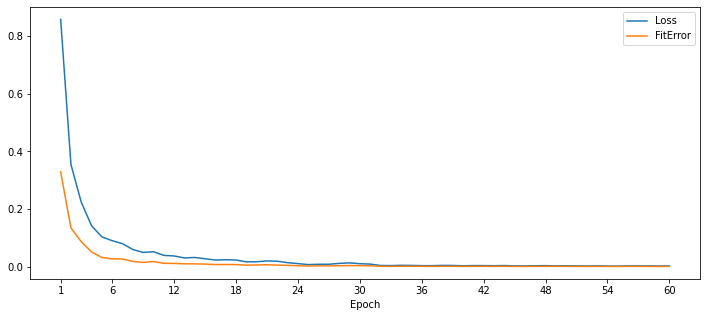

In [42]:
# Plot the training history of 'model_m' to
# display the changing model loss and fit 
# error values over 60 epochs.
# model_m.plot_training_history()
model_m.plot_training_history(items=['Loss', 'FitError'], 
                              fig_size=(12,5), 
                              tick_frequency=6
                              )

We have seen the training history learning curve for the <b>training data</b>. What does the training history learning curve for the <b>validation data</b> look like? 

To see the training history for the validation data set loss and fit error statistics, use the `ValidLoss` and `ValidError` items with the SAS DLPy `plot_training_history()` function:

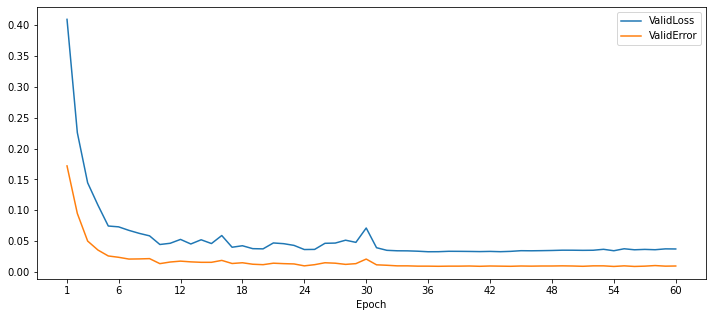

In [43]:
model_m.plot_training_history(items=['ValidLoss', 'ValidError'], 
                              fig_size=(12,5), 
                              tick_frequency=6
                              )

When comparing training data set learning curves to validation data set learning curves, the training data set loss statistics for the model are expected to be lower than the validation data set loss statistics. This difference is normal and expected. The term for the differential gap is between train data set and validation data set loss is called the `generalization gap`.

The example plots show a stable model with good training and validation loss and fit error statistics. 

<a id="Plots"></a>

### Examine Neural Network Classification Model Performance Metrics

Now we can use a variety of scored model metrics to assess the performance of the neural network model `model_m`. In this section we use the scored data to calculate the model confusion matrix, the model accuracy score, the ROC curve, the area under ROC curve (AUC), the Precision-Recall curve, and the model's F1 score.

Use the `predict()` function for `model_m` with `test_tbl` to score the test data for model fit evaluation. Use the best-fitting model weights found during training, as opposed to the model weights associated with the final epoch of optimization. Save the scored CAS data in `model_m.valid_res_tbl` to Python as `test_result_table`.

In [44]:
# Use model_m to score the test data set test_tbl
model_m.predict(test_tbl,
                use_best_weights=True
                )

NOTE: Using the weights providing the smallest loss error.


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read          6584
 1  Number of Observations Used          6584
 2  Misclassification Error (%)      9.325638
 3                   Loss Error      0.495392

[OutputCasTables]

             casLib              Name  Rows  Columns  \
 0  CASUSER(UserID)  Valid_Res_9a58qB  6584      250   
 
                                             casTable  
 0  CASTable('Valid_Res_9a58qB', caslib='CASUSER(U...  

+ Elapsed: 0.882s, user: 23.1s, sys: 0.0984s, mem: 140mb

The model `model_m` scored the test data with a misclassification rate of 9.325% and a loss error of 0.4953. These are encouraging model performance statistics. Save the scored table to use for generating additional model performance metrics.

In [45]:
# Save the scored CAS table model_m.valid_res_tbl
# to Python as test_result_table
test_result_table = model_m.valid_res_tbl

<a id="confusionMatrix"></a>

#### Evaluate the Confusion Matrix

First, show the confusion matrix for the `model_m` scored data in test_result_table. The confusion matrix is a performance measurement for deep learning classification models. The confusion matrix is a table that shows a summary of the model's predicted values versus actual ground truth values.

In [46]:
# Show the confusion matrix for the 
# scored test data by activity type 
display(confusion_matrix(test_result_table['Activity'], 
                         test_result_table['I_Activity']
                         )
        )

,0,1,2,3,4,5
Activity,,,,,,
0.0,444.0,36.0,0.0,0.0,76.0,94.0
1.0,18.0,1879.0,0.0,0.0,57.0,36.0
2.0,13.0,0.0,413.0,24.0,2.0,0.0
3.0,1.0,0.0,15.0,352.0,1.0,1.0
4.0,80.0,27.0,0.0,1.0,567.0,50.0
5.0,9.0,71.0,0.0,0.0,2.0,2315.0


<a id="predAccuracy"></a>

#### Calculate the Model's Predictive Accuracy
Based on the test data set score, what is the model's predictive accuracy? Use the `accuracy_score()` function to create the output table `acc_score`, and use the `print()` function to display it. 

In multi-label classification, the accuracy function computes subset accuracy for predicted and ground truth labels. Accuracy scores range from 0 to 1. Model accuracy score values that are very close to 1 indicate higher model accuracy.

In [47]:
# Calculate the accuracy score
acc_score = accuracy_score(test_result_table['Activity'], 
                           test_result_table['I_Activity']
                           )
print('The accuracy score for the test data is {:.6f}.'.format(acc_score))

The accuracy score for the test data is 0.906744.


The accuracy score of 0.906744 is indicative of a strong model.

<a id="rocAUC"></a>

#### Assess ROC Curve and Calculate AUC

As another performance measure, use the scored test results in `test_result_table` with the `plot_roc()` function to generate a plot of the ROC curve for the `downstairs` target class (`target_class`=1). The ROC curve is a graphical plot that illustrates the performance of a classification system as its discrimination threshold is varied.

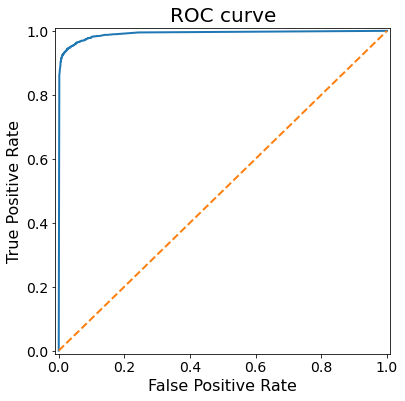

In [48]:
# Plot the ROC curve for target_class = 1
plot_roc(test_result_table['Activity'], 
         test_result_table['P_Activity1'], 
         pos_label=1, 
         figsize=(6,6), 
         linewidth=2
         )

The ROC curve rises aggressively towards the ideal predictor's perfect true positive rate of 1.0. This is a strong ROC curve.

Now use the SAS DLPy function `roc_auc_score()` with the scored test table `test_result_table` with `P_target_class1` to calculate the AUC, the area under the ROC curve.

AUC, or the area under the ROC curve, is another way of conveying the information in an ROC plot. performance measurement for the classification model at various threshold settings. AUC indicates how well the model performs in distinguishing between classes. The score is a value between 0.0 and 1.0, with a value of 1.0 being a perfect classifier. The closer to 1 the AUC score is, the better the model performs for the classification task. 

In [49]:
# Calculate the area under the ROC curve.
auc_of_roc = roc_auc_score(test_result_table['Activity'], 
                           test_result_table['P_Activity1'], 
                           pos_label=1
                           )
print('The AUC area under the ROC curve for the scored test data is {:.6f}.'.format(auc_of_roc))

The AUC area under the ROC curve for the scored test data is 0.990928.


The AUC score of 0.990928 is very close to 1 and is indicative of a strong model.

<a id="precisionRecall"></a>

#### Evaluate Precision-Recall Curve

Now use the function `plot_precision_recall()` with the scored test table `test_result_table` and `P_Activity1` to generate the Precision-Recall curve for target class 1.

Precision is a metric that quantifies the number of correct positive predictions that were made. It is calculated as the number of true positives divided by the total number of true positives and false positives. The result is a value between 0.0 for no precision and 1.0 for full or perfect precision.

Recall is a metric that describes the number of correct positive predictions made out of all positive predictions that could have been made. It is calculated as the number of true positives divided by the total number of true positives and false negatives. In other words, recall represents the true positive rate. The result is a value between 0.0 for no recall and 1.0 for perfect recall.

A Precision-Recall curve is a plot of the precision (y-axis) and the recall (x-axis) for different probability thresholds. 

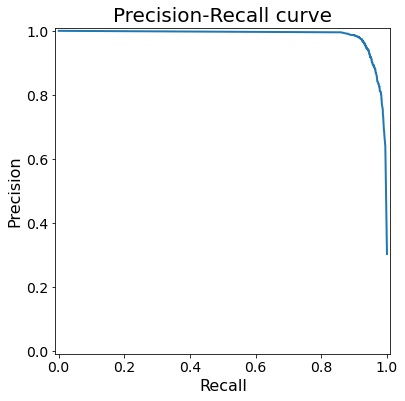

In [50]:
# Plot the precision recall curve for target_class = 1
plot_precision_recall(test_result_table['Activity'], 
                      test_result_table['P_Activity1'], 
                      pos_label=1, 
                      figsize=(6,6), 
                      linewidth=2
                      )

The plotted precision-recall curve bows heavily towards the ideal result of perfect precision and recall. A poor classification model would be a horizontal line on the plot. This is a very strong precision-recall curve for the model.


<a id="f1Average"></a>

#### Evaluate Average Precision Score and F1 Score

Now use the function `average_precision_score()` with the scored test table `test_result_table` and `P_Activity1` to calculate the model's average precision score for target class 1. For a classification task, average precision summarizes a Precision-Recall curve as the weighted mean of precisions achieved at each threshold. The increase in recall from the previous threshold becomes the weight. Average precision scores range from 0 to 1. The closer the score is to 1, the better the precision of the model.

In [51]:
# Calculate the average precision score for target_class = 1
ap = average_precision_score(test_result_table['Activity'], 
                             test_result_table['P_Activity1'], 
                             pos_label=1
                             )
print('The average precision score for the scored test data is {:.6f}.'.format(ap))

The average precision score for the scored test data is 0.982287.


The average precision score for the model is 0.982287, indicating a strong model.

Finally, use the function `f1_score()` with the scored test table `test_result_table` and `I_Activity` to calculate the F1 score for target class 1. The F1 score represents a weighted average of the scoring model's precision and recall. The best score for an F1 value is 1, and the worst score is 0. The influences of precision and recall on the f1 score are equal.

The closer the F1 score is to 1.0, the greater the model performance. 

In [52]:
# Calculate the f1 score for target_class 1
f1sc = f1_score(test_result_table['Activity'], 
                test_result_table['I_Activity'], 
                pos_label=1
                )
print('The F1 score for the scored test data is {:.6f}.'.format(f1sc))


The F1 score for the scored test data is 0.938796.


The F1 score of 0.938796 for the neural network activity classification model is close to 1.0. This is a good f1 score, indicative of a robust classification model.

<a id="summary"></a>

### Summary

It is relatively easy to create and modify task-centric models using SAS DLPy. This example showed how to use SAS DLPy to create a deep neural network 1D convolutional model for an activity classification task using tabular movement data. It showed how to use DLPy to score data with a trained model, and it also showed how to use DLPy to generate and view multiple performance metrics (ROC, AUC, Precision-Recall curve, Average Precision score, and F1 score) using scored data table output from the trained neural network model.